In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from ast import literal_eval
from zipfile import ZipFile
import os
import random

# Movie Recommendation System
### Eva Burns

## Problem Statement

Everyone has encountered this problem before: you sit down to watch a movie, have no idea what to watch or what you think you would like. To solve this, I will create a recommendation system using about 9.6 million ratings from 100,000 users. The recommendations for each user are created by predicting what the user will rate each movie, and recommending the highest predicted rated movies.

The dataset was found at [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) on Kaggle. This dataset consists of more files on the content information about the movies such as cast and crew, but I will focus on the following files for this recommender:

[movies_metadata.csv](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv): The main Movies Metadata file. Contains information on 45,000 movies found on TMDB. Relevant features include id, title, genres, popularity, vote_average, and vote_count

[ratings_small.csv](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings_small.csv): The subset of 100,000 ratings from 700 users on 9,000 movies. This is used for development and testing the model before using more data.

[ratings.csv](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings.csv): The full 26 million ratings from 270,000 users for all 45,000 movies.

## Assumptions/Hypotheses about data and model

Because ratings are user inputted, there are biases involved in the data. There are certain groups of people who may leave ratings on movies: critics and people who feel very strongly about the movie (both positively and negatively). For the purposes of this project, I will assume that the ratings are representative of the general population.

In [2]:
SOURCE_PATH = './data'

if (not os.path.exists(f'{SOURCE_PATH}/movies_metadata.csv')) | (not os.path.exists(f'{SOURCE_PATH}/ratings_small.csv')) | (not os.path.exists(f'{SOURCE_PATH}/ratings.csv')):
    zip = ZipFile(f'{SOURCE_PATH}/movie_data.zip')
    zip.extractall(path = SOURCE_PATH)
    zip.close()

    os.rmdir(f'{SOURCE_PATH}/__MACOSX')
    
movies_metadata = pd.read_csv(f'{SOURCE_PATH}/movies_metadata.csv', low_memory=False)
ratings_small = pd.read_csv(f'{SOURCE_PATH}/ratings_small.csv') # Used for testing and building purposes
ratings = pd.read_csv(f'{SOURCE_PATH}/ratings.csv')

I will be taking a subset of the full ratings dataset. This will be done by taking a random sample without replacement of size 100,000 from all of the unique user ids and getting their ratings. The reason I did not just randomly split the entire ratings dataset is because I want every user represented in the dataset to have their full ratings. That is more useful to the model to know 

In [3]:
random.seed(123)
ids = random.sample(list(set(ratings['userId'])), 10000)
ratings_medium = ratings[ratings['userId'].isin(ids)] 
len(ratings_medium)

954874

### Data Cleaning

From the movies metadata dataset, I will drop some of the columns that will not be useful for this project.

In [4]:
movies_md = movies_metadata.copy()
movies_md = movies_md.drop(["homepage", "status", "video", "poster_path", "belongs_to_collection", 'adult', 'original_language', 'production_countries', 'original_title'], axis=1)

I also would like to convert the id column to int and the popularity column to float. However, there were some issues with the data imputation, and have some weird strings as a data point. Those will be made into null values and then dropped.

In [5]:
def convert_float(x):
    try:
        return float(x)
    except:
        return np.nan

movies_md['popularity'] = movies_md['popularity'].apply(convert_float)
movies_md['id'] = movies_md['id'].apply(convert_float)

n_orig = len(movies_md['popularity'])

movies_md = movies_md[(movies_md['popularity'].notna()) & (movies_md['id'].notna())]
movies_md['id'] = movies_md['id'].astype(int)
n_new = len(movies_md['popularity'])

print(f"Number rows dropped: {n_orig - n_new}")

Number rows dropped: 6


I will also be evaluating the genres of the movies later, so I will convert them from a dictionary/json format to a list.

In [6]:
movies_md['genres'] = movies_md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

## Exploratory Data Analysis

I will begin by examining the most popular movies. A popularity score is calculated by TMDB basically by how much users interact with the movie (rating, viewing, favoriting, etc.)

In [7]:
simplified_md = movies_md[['id','title', 'popularity', 'genres']].sort_values(by='popularity', ascending=False)

grouped = ratings.groupby('movieId')

mean_ratings = grouped.mean()['rating']
num_ratings = grouped.count()['rating']

movie_ratings = pd.DataFrame({'avg_rating':mean_ratings, 'ratings_count': num_ratings}).reset_index()

simplified_md = simplified_md.merge(movie_ratings, left_on='id', right_on='movieId').drop('movieId', axis=1)

simplified_md.head(15)

,id,title,popularity,genres,avg_rating,ratings_count
0,680,Pulp Fiction,140.950236,"[Thriller, Crime]",3.552970,1246
1,155,The Dark Knight,123.167259,"[Drama, Action, Crime, Thriller]",3.395375,1319
2,78,Blade Runner,96.272374,"[Science Fiction, Drama, Thriller]",3.173709,1278
3,119450,Dawn of the Planet of the Apes,75.385211,"[Science Fiction, Action, Drama, Thriller]",3.000000,1
4,550,Fight Club,63.869599,[Drama],3.083261,3477
5,118340,Guardians of the Galaxy,53.291601,"[Action, Science Fiction, Adventure]",4.000000,1
6,278,The Shawshank Redemption,51.645403,"[Drama, Crime]",3.021647,1178
7,13,Forrest Gump,48.307194,"[Comedy, Drama, Romance]",3.326442,1838
8,22,Pirates of the Caribbean: The Curse of the Bla...,47.326665,"[Adventure, Fantasy, Action]",3.300608,11026
9,11,Star Wars,42.149697,"[Adventure, Action, Science Fiction]",3.660591,19475


Text(0.5, 1.0, 'Popular Movies')

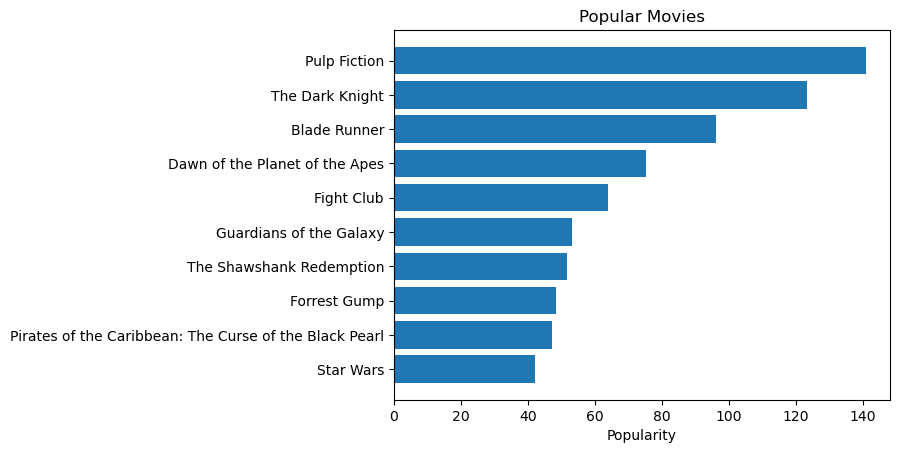

In [8]:
top_pop = simplified_md.head(10)

plt.barh(top_pop['title'],top_pop['popularity'])
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

Below is the distribution of genres for the top 25 most popular movies.

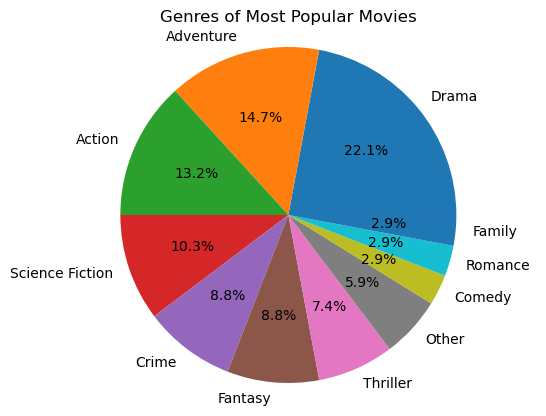

In [9]:
def count_genres(genre_series):
    total_ct = 0
    counts = dict()
    counts['Other'] = 0
    for genres in genre_series:
        for genre in genres:
            if genre not in counts.keys():
                counts[genre] = 1
            else: 
                counts[genre] += 1
            total_ct += 1
    
    for key in counts.keys():
        if counts[key] < .02 * total_ct:
            counts['Other'] += 1
            counts[key] = 0
    
    filtered_dict = {k:v for k,v in counts.items() if v != 0}
    return dict(sorted(filtered_dict.items(), key=lambda x:x[1], reverse=True))

popular_genres = count_genres(simplified_md.head(25)['genres'])

plt.pie(popular_genres.values(), labels=popular_genres.keys(), autopct='%1.1f%%')
plt.title("Genres of Most Popular Movies")
plt.axis('equal')
plt.show()

Now, I will examine the highest rated movies. I will do a few transformations to get a better idea of what is considered the highest rated movie. There are movies that only have one rating, so giving them the same weight as another movie with 10,000 ratings seems unreasonable. So first, I will filter out the movies in the lowest 10% of number of ratings. Then, I will calculate a weighted rating inspired by this formula used by IMDB:

$$\text{Weighted Rating (WR)} = \left( \frac{v}{v+m} \cdot R\right) + \left( \frac{m}{v+m} \cdot C\right)$$

$v$ is the number of votes for the movie

$m$ is the minimum votes required to be listed in the chart

$R$ is the average rating of the movie

$C$ is the mean vote across the whole report

In [10]:
C = simplified_md['avg_rating'].mean()
m = simplified_md['ratings_count'].quantile(0.9)

def weighted_rating(x, m=m, C=C):
    v = x['ratings_count']
    R = x['avg_rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

filtered_movies = simplified_md.copy().loc[simplified_md['ratings_count'] >= m]

filtered_movies['score'] = filtered_movies.apply(weighted_rating, axis=1)

filtered_movies = filtered_movies.sort_values(by="score", ascending=False)
filtered_movies.head(15)

,id,title,popularity,genres,avg_rating,ratings_count,score
2271,318,The Million Dollar Hotel,4.938231,"[Drama, Thriller]",4.429015,91082,4.382976
925,858,Sleepless in Seattle,10.234919,"[Comedy, Drama, Romance]",4.339811,57070,4.272782
2526,527,Once Were Warriors,4.025276,[Drama],4.266531,67662,4.212948
1680,2959,License to Wed,7.102076,[Comedy],4.230716,60024,4.172561
72,296,Terminator 3: Rise of the Machines,20.818907,"[Action, Thriller, Science Fiction]",4.169975,87901,4.131812
768,593,Solaris,11.059785,"[Drama, Science Fiction, Adventure, Mystery]",4.152246,84078,4.113090
1091,912,The Thomas Crown Affair,9.444818,"[Romance, Crime, Thriller, Drama]",4.214393,30043,4.105640
4844,58559,Confession of a Child of the Century,0.778480,[Drama],4.182071,39600,4.100037
1638,750,Murder She Said,7.261845,"[Drama, Crime, Mystery, Comedy]",4.213030,28280,4.098358
2028,260,The 39 Steps,5.865697,"[Action, Thriller, Mystery]",4.132299,77045,4.090546


Text(0.5, 1.0, 'High Scoring Movies')

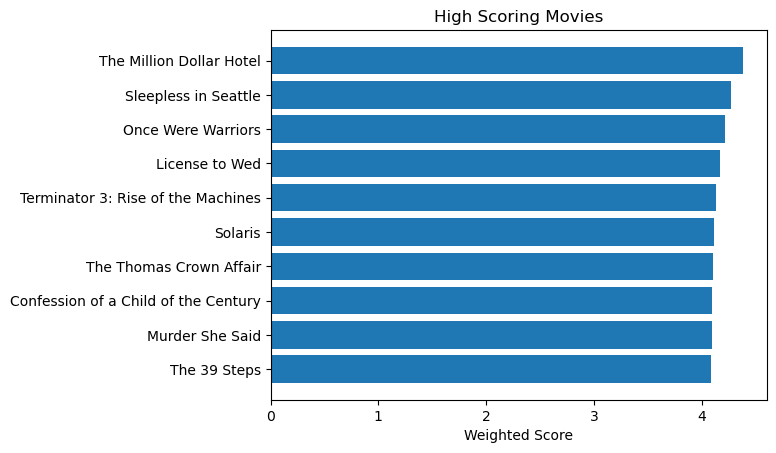

In [11]:
top_score = filtered_movies.head(10)

plt.barh(top_score['title'],top_score['score'])
plt.gca().invert_yaxis()
plt.xlabel("Weighted Score")
plt.title("High Scoring Movies")

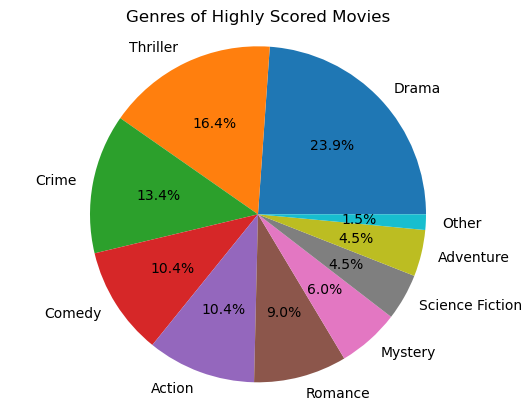

In [12]:
high_score_genres = count_genres(filtered_movies.head(25)['genres'])

plt.pie(high_score_genres.values(), labels=high_score_genres.keys(), autopct='%1.1f%%')
plt.title("Genres of Highly Scored Movies")
plt.axis('equal')
plt.show()

## Feature Engineering & Transformations

## Proposed Approaches (Model) with checks for overfitting/underfitting

Collaborative Filtering

In [13]:
reader = Reader()

data = Dataset.load_from_df(ratings_medium[['userId', 'movieId', 'rating']], reader)

svd = SVD()

## Proposed Solution (Model Selection) with regularization, if needed

In [14]:
import time
start = time.time()

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

end = time.time()
print(f"\nTime elasped: {round(end-start, 3)} seconds ({round(len(ratings_medium)/(end-start), 3)} ratings per second)", )

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8608  0.8581  0.8581  0.8567  0.8565  0.8580  0.0015  
MAE (testset)     0.6558  0.6540  0.6542  0.6527  0.6527  0.6539  0.0012  
Fit time          4.19    4.77    4.28    4.23    4.55    4.41    0.22    
Test time         0.65    0.69    0.70    0.66    0.68    0.68    0.02    

Time elasped: 29.612 seconds (32245.69 ratings per second)


## Results (Accuracy) and Learnings from the methodology

In [15]:
trainset = data.build_full_trainset()

svd.fit(trainset)

In [16]:
user_id = ids[100]

user_hist = ratings_medium[ratings_medium['userId'] == user_id].merge(movies_md[['id', 'title', 'genres']], left_on='movieId', right_on="id")
user_hist = user_hist.sort_values(by='rating', ascending=False)
user_hist

,userId,movieId,rating,timestamp,id,title,genres
0,227122,345,5.0,1246787949,345,Eyes Wide Shut,"[Mystery, Drama]"
5,227122,924,5.0,1246787779,924,Dawn of the Dead,"[Fantasy, Horror, Action]"
15,227122,44555,5.0,1246788227,44555,"A Woman, a Gun and a Noodle Shop","[Comedy, Drama, Thriller]"
12,227122,8973,5.0,1246789196,8973,Lord of Illusions,"[Mystery, Horror, Thriller]"
10,227122,3083,5.0,1246788054,3083,Mr. Smith Goes to Washington,"[Comedy, Drama]"
13,227122,39183,4.5,1246788609,39183,Once in a Lifetime: The Extraordinary Story of...,[Documentary]
14,227122,43376,4.5,1246788264,43376,Diary of a Country Priest,[Drama]
6,227122,1103,4.0,1246787622,1103,Escape from New York,"[Science Fiction, Action]"
11,227122,4967,4.0,1246788380,4967,Keeping the Faith,[Comedy]
3,227122,922,4.0,1246787620,922,Dead Man,"[Drama, Fantasy, Western]"


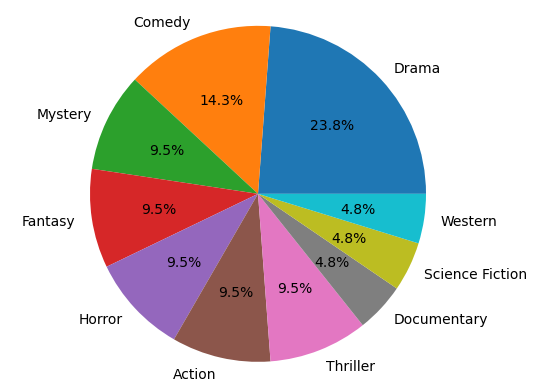

In [17]:
if len(user_hist) < 10:
    user_genre_count = count_genres(user_hist['genres'])
else:
    user_genre_count = count_genres(user_hist.head(10)['genres'])

plt.pie(user_genre_count.values(), labels=user_genre_count.keys(), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [18]:
def get_recommendations_for_user(user_id):
    est_ratings = []
    for i, row in filtered_movies.iterrows():
        movie_id = int(row['id'])
        title = row['title']
        est_rat = svd.predict(user_id, movie_id).est
        est_ratings += [[movie_id, row['title'], est_rat, row['genres']]]

    recommendation = pd.DataFrame(est_ratings, columns=["movieId", "title", "estimated_rating", 'genres'])
    recommendation = recommendation[~recommendation['movieId'].isin(ratings[ratings['userId'] == user_id]['movieId'])]
    return recommendation.sort_values(by='estimated_rating', ascending=False)

user_rec = get_recommendations_for_user(user_id).head(10)

user_rec

,movieId,title,estimated_rating,genres
105,905,Pandora's Box,4.393716,"[Drama, Thriller, Romance]"
46,953,Madagascar,4.338538,"[Family, Animation]"
47,5971,We're No Angels,4.243593,"[Comedy, Crime, Drama]"
30,913,The Thomas Crown Affair,4.227379,"[Drama, Crime, Romance]"
215,534,Terminator Salvation,4.169603,"[Action, Science Fiction, Thriller]"
109,928,Gremlins 2: The New Batch,4.135304,"[Comedy, Horror, Fantasy]"
26,2762,Young and Innocent,4.079673,"[Drama, Crime]"
278,3060,The Big Parade,4.070152,"[Drama, Romance, War]"
188,290,Barton Fink,4.062039,"[Comedy, Drama]"
111,909,Meet Me in St. Louis,4.051369,"[Comedy, Music, Romance]"


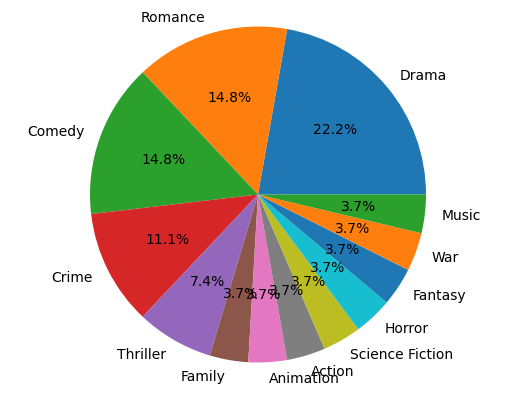

In [19]:
rec_genre_count = count_genres(user_rec['genres'])

plt.pie(rec_genre_count.values(), labels=rec_genre_count.keys(), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

## Future Work

There was a good portion of the data from kaggle I did not use, mainly information about the movies such as cast, crew, keywords from the description, and genre. Next steps would be to make a hybrid recommender that incorporates the svd model already made with some of the movie information. For example, based on the movies the user gave a high rating for, find movies that other users also liked (SVD). Then, find movies that have similar plots, cast, or genre to the movies the user already liked.

I think incorporating these multiple aspects could make an even more accurate recommender.

In [20]:
os.remove(f'{SOURCE_PATH}/movies_metadata.csv')
os.remove(f'{SOURCE_PATH}/ratings_small.csv')
os.remove(f'{SOURCE_PATH}/ratings.csv')